### Evaluation Classification model

This scripts tests the MobileNet classification model trained on the LaRED dataset. The test set consists of a total of 2850 images. This corresponds to 19% of the total amount of images in the training and test set. 1500 of the test images have been taken from a dedicated subject that has not been included in the training set. This allows to test the model on a set of images of a person that it has not seen before. The remaining 1350 test images have been taken randomly from the remaining 9 subjects to add some more diverse images to the test set.

All needed adjustments ti this script are marked with "Todo".

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# ToDo: Only necessary if you changed the selected gestures in the script data_preprocessing_lared.ipynb.
# adjust the names and quantity of the gestures here too.

INDEX_TO_LABEL = {
    0 :"crawl",
    1 :"fist",
    2 :"five",
    3 :"palm",
    4 :"peace",
}

NUMBER_OF_CLASSES = 5

# Todo: change path to the test directory wich contains manually cropped images, cropped with the help of mask files
TEST_DIR_64x64 = "C:/datasets/lared/cropped_gesture64x64/test"

### Load data


In [3]:
def images_to_array(path):
    """ This method takes a path containing images in different folders representing the classes.
    Parameters:
        path (str): path to image folder
    Returns:
        Two arrays containing the images and corresponding labels
     """
    images = []
    labels = []

    curr_label = 0
    
    for dir_gesture in os.listdir(path):
        curr_dir = os.path.join(path, dir_gesture)
        curr_files = os.listdir(curr_dir)
        
        print(dir_gesture)
        
        for file in curr_files:
            img_path = os.path.join(curr_dir, file)
            image_as_array = cv2.imread(img_path)
            # image_as_array = cv2.resize(image_as_array, (IMAGE_HEIGHT,IMAGE_WIDTH))
            image_as_array = cv2.cvtColor(image_as_array, cv2.COLOR_BGR2RGB)

            images.append(image_as_array)
            labels.append(tf.keras.utils.to_categorical(curr_label,NUMBER_OF_CLASSES))
  
        curr_label = curr_label + 1
        
    return images, labels

test_images64x64, test_labels64x64 =  images_to_array(TEST_DIR_64x64)

print("image_data_format()", tf.keras.backend.image_data_format())
print("Test images      ",len(test_images64x64),  np.array(test_images64x64[0]).shape,  
      " Test labels ", len(test_labels64x64))

crawl
fist
five
palm
peace
image_data_format() channels_last
Test images       2850 (64, 64, 3)  Test labels  2850


### Load classification model

In [4]:
model_dir = Path("../3_classification/model_mobilenet")
model_classify = tf.saved_model.load(str(model_dir))
print("gesture classification model loaded")

gesture classification model loaded


### Run test

In [5]:
def classify_gesture(img):

    # preprocess image
    img = img/255
    img = img.astype('float32')
    input_tensor = tf.convert_to_tensor(img)
    input_tensor = input_tensor[tf.newaxis,...]

    # run classification model
    prediction = model_classify(input_tensor)

    # format prediction
    predicted_index = np.argmax(prediction, axis=1)[0]

    return predicted_index

In [6]:
y_true = np.argmax(test_labels64x64, axis=1)

y_pred = []
for img in test_images64x64:
    y_pred.append(classify_gesture(img))

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
target_names = ['crawl','fist', 'five', 'palm', 'peace']    

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

Confusion Matrix
[[570   0   0   0   0]
 [  0 570   0   0   0]
 [  5   0 565   0   0]
 [  0   0   0 570   0]
 [  0   0   0   0 570]]
Classification Report
              precision    recall  f1-score   support

       crawl     0.9913    1.0000    0.9956       570
        fist     1.0000    1.0000    1.0000       570
        five     1.0000    0.9912    0.9956       570
        palm     1.0000    1.0000    1.0000       570
       peace     1.0000    1.0000    1.0000       570

    accuracy                         0.9982      2850
   macro avg     0.9983    0.9982    0.9982      2850
weighted avg     0.9983    0.9982    0.9982      2850



### Show all misclassified images

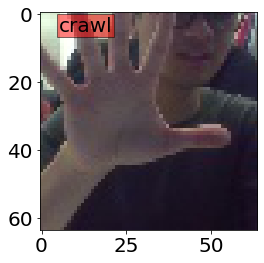

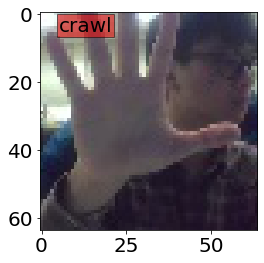

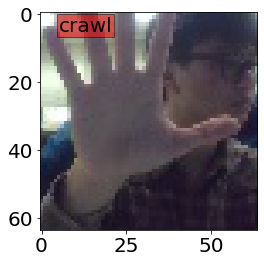

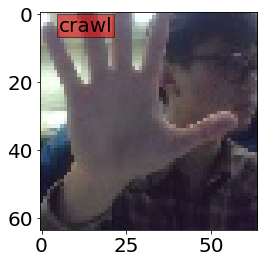

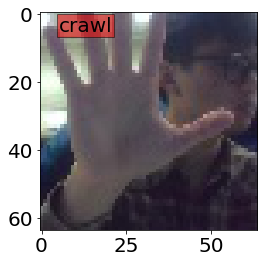

In [7]:
plt.rc('font', size=20)

for img, true_label, pred_label in zip(test_images64x64, y_true, y_pred):
    if true_label != pred_label:
        plt.imshow(img)
        label = INDEX_TO_LABEL[pred_label]
        plt.text(5,5,label, bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
        plt.show()